# Solar Energy Data Loading and Overview

This notebook demonstrates how to load and get an overview of solar energy data using the hybrid CSV/API approach.

**Key Features:**
- Load historical CSV data (2+ years of 15-minute intervals)
- Load recent API data for up-to-date information
- Combine data sources intelligently
- Basic data validation and statistics

In [1]:
# Import libraries
import sys
sys.path.append('../src')

# NEW: Import the enhanced utilities for streamlined data loading
from core.notebook_data import load_with_quality_report, print_data_overview
from core.data_manager import SolarDataManager
from visualization.solar_charts import SolarVisualizationSuite
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("📊 Solar Energy Data Analysis - Data Loading & Overview (Enhanced)")
print("=" * 65)
print("🆕 Now using the new Data Loading Utilities for streamlined analysis!")
print("=" * 65)

📊 Solar Energy Data Analysis - Data Loading & Overview (Enhanced)
🆕 Now using the new Data Loading Utilities for streamlined analysis!


/Users/christopherhaught/projects/power-usage-and-consumption/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Enhanced Data Loading with Quality Analysis

**NEW APPROACH:** Instead of manually setting up data detection and loading (15+ lines), 
we now use the new Data Loading Utilities that consolidate all the setup and provide 
comprehensive quality analysis in a single function call.

In [2]:
# 🆕 NEW: Load data with comprehensive quality analysis in one call
# This replaces the previous 15+ lines of manual setup with 1 streamlined call

print("🚀 Loading solar data with new Data Loading Utilities...")
result = load_with_quality_report(source='smart')

# Extract the loaded datasets
csv_data = result['fifteen_min_data']
daily_data = result['daily_data']
quality_report = result['quality_report']

# Display professional data overview
print_data_overview(csv_data, "15-Minute Solar Data")
print_data_overview(daily_data, "Daily Solar Summary")

print("✅ Data loading complete with new enhanced utilities!")

INFO:data.loaders:Loading CSV data from ../data/raw/4136754_custom_report.csv


🚀 Loading solar data with new Data Loading Utilities...
📊 Determining Best Data Source...
✅ Using REAL Enphase API credentials!
   📈 Will attempt to fetch live data from your solar system
   🎯 PRIORITY: Real Enphase API data from your solar system
   📡 Will attempt live API data first
   📁 CSV fallback: ../data/raw/4136754_custom_report.csv

📋 Available Data Sources (in priority order):
   🎯 SELECTED: 📈 REAL CSV DATA - Real solar panel CSV data through 2025
      Available: 🎭 SYNTHETIC/MOCK DATA - Synthetic data for Holly Springs, NC (ends June 2024)
      Available: 🎭 GENERIC MOCK DATA - Generic synthetic data (ends March 2024)


INFO:data.loaders:Applied intelligent column standardization
INFO:data.loaders:Successfully loaded 70272 records from ../data/raw/4136754_custom_report.csv
INFO:core.data_manager:Loaded 70272 CSV records from 2023-09-16 00:00:00 to 2025-09-16 23:45:00
INFO:core.data_manager:Loading API data for last 30 days


Error getting lifetime energy: 401


INFO:data.quality:Generating comprehensive quality report
INFO:data.quality:Generating comprehensive quality report



📊 15-Minute Solar Data

📈 Basic Info:
  • Shape: (70272, 4)
  • Columns: ['Production (kWh)', 'Consumption (kWh)', 'Export (kWh)', 'Import (kWh)']
  • Date range: 2023-09-16 to 2025-09-16
  • Duration: 731 days

📋 Data Quality:
  • No missing values ✅

📊 Summary Statistics:
       Production (kWh)  Consumption (kWh)  Export (kWh)  Import (kWh)
count          70272.00           70272.00      70272.00      70272.00
mean               0.39               0.37          0.26          0.24
std                0.62               0.51          0.50          0.47
min                0.00               0.00          0.00          0.00
25%                0.00               0.11          0.00          0.00
50%                0.00               0.18          0.00          0.10
75%                0.57               0.41          0.20          0.24
max                1.92               5.36          1.86          5.12

📊 Daily Solar Summary

📈 Basic Info:
  • Shape: (732, 4)
  • Columns: ['Production (

## 2. Professional Data Quality Report

**NEW FEATURE:** The utilities automatically generate a comprehensive quality report 
that replaces manual data validation checks with professional analysis.

In [3]:
# 🆕 NEW: Display comprehensive quality report (replaces manual validation)
print("📋 COMPREHENSIVE DATA QUALITY REPORT")
print("=" * 50)
print(quality_report)

# 🆕 NEW: Access data with enhanced metadata
print("\n📊 ENHANCED DATA INFORMATION:")
print(f"Dataset shape: {csv_data.shape}")
print(f"Columns: {list(csv_data.columns)}")
print(f"Date range: {csv_data.index.min()} to {csv_data.index.max()}")
print(f"Data source: {csv_data.attrs.get('source', 'unknown')}")
print(f"Granularity: {csv_data.attrs.get('granularity', 'unknown')}")
print(f"Loaded at: {csv_data.attrs.get('loaded_at', 'unknown')}")

print("\n=== First 5 rows ===")
print(csv_data.head())

📋 COMPREHENSIVE DATA QUALITY REPORT
📊 DATA QUALITY REPORT

📈 Dataset Overview:
  • Records: 70,272
  • Columns: 4
  • Date range: 2023-09-16 to 2025-09-16

📋 Data Completeness:
  • Overall: 100.0%
  • Total cells: 281,088
  • Non-null cells: 281,088

🔍 Data Integrity:
  • Quality score: 92.0/100
  • Issues found: 0
  • Warnings: 4

⚠️ Warnings:
  • 8694 potential outliers in Production (kWh)
  • 7609 potential outliers in Consumption (kWh)
  • 13895 potential outliers in Export (kWh)
  • 6599 potential outliers in Import (kWh)

✅ Overall Assessment:
  🟢 Excellent data quality - ready for analysis

📊 ENHANCED DATA INFORMATION:
Dataset shape: (70272, 4)
Columns: ['Production (kWh)', 'Consumption (kWh)', 'Export (kWh)', 'Import (kWh)']
Date range: 2023-09-16 00:00:00 to 2025-09-16 23:45:00
Data source: csv
Granularity: 15min
Loaded at: 2025-09-28 14:52:19.877671

=== First 5 rows ===
                     Production (kWh)  Consumption (kWh)  Export (kWh)  \
Date/Time                       

## 3. Enhanced Daily Data Analysis

**NEW FEATURE:** Daily data is automatically created with enhanced processing 
and comprehensive metrics built-in.

In [4]:
# 🆕 NEW: Enhanced daily data analysis with automatic calculations
from core.notebook_data import quick_column_detection

print("📈 ENHANCED DAILY PRODUCTION ANALYSIS")
print("=" * 50)

print(f"Daily data shape: {daily_data.shape}")
print(f"Date range: {daily_data.index.min().date()} to {daily_data.index.max().date()}")

# 🆕 NEW: Use ColumnMapper utility instead of manual detection (replaces 10+ lines)
energy_columns = quick_column_detection(daily_data, print_summary=False)
production_col = energy_columns.get('production')
consumption_col = energy_columns.get('consumption')

print(f"✅ Auto-detected production column: {production_col}")
print(f"✅ Auto-detected consumption column: {consumption_col}")

# Check if enhanced metrics are available
if 'Net Energy (kWh)' in daily_data.columns:
    print("\n✨ Enhanced metrics detected!")
    print(f"Average net energy: {daily_data['Net Energy (kWh)'].mean():.1f} kWh/day")
    
if 'Self Sufficiency (%)' in daily_data.columns:
    print(f"Average self-sufficiency: {daily_data['Self Sufficiency (%)'].mean():.1f}%")

# Standard statistics using detected column names
if production_col:
    print(f"\nAverage daily production: {daily_data[production_col].mean():.1f} kWh")
    print(f"Peak daily production: {daily_data[production_col].max():.1f} kWh")
    print(f"Total production: {daily_data[production_col].sum():,.0f} kWh")

if production_col and consumption_col:
    net_energy = daily_data[production_col] - daily_data[consumption_col]
    surplus_days = (net_energy > 0).sum()
    print(f"Days with surplus: {surplus_days}/{len(daily_data)} ({surplus_days/len(daily_data)*100:.1f}%)")

# Display statistical summary
print("\n=== DAILY SUMMARY STATISTICS ===")
print(daily_data.describe())

print(f"\n💡 Column Detection Enhancement:")
print(f"  • Old manual detection: 10+ lines of for loops")
print(f"  • New ColumnMapper utility: 1 line with intelligent detection")
print(f"  • Automatic standardization: Built into data loading")

📈 ENHANCED DAILY PRODUCTION ANALYSIS
Daily data shape: (732, 4)
Date range: 2023-09-16 to 2025-09-16
✅ Auto-detected production column: Production (kWh)
✅ Auto-detected consumption column: Consumption (kWh)

Average daily production: 37.4 kWh
Peak daily production: 61.3 kWh
Total production: 27,398 kWh
Days with surplus: 404/732 (55.2%)

=== DAILY SUMMARY STATISTICS ===
       Production (kWh)  Consumption (kWh)  Export (kWh)  Import (kWh)
count        732.000000         732.000000    732.000000    732.000000
mean          37.429422          35.981697     24.618269     23.170534
std           15.140412          19.901281     13.496543     14.259315
min            0.633000           8.806000      0.000000      4.292000
25%           28.072750          21.744500     13.741500     12.917250
50%           40.747500          30.490500     25.774500     18.521500
75%           49.822500          46.256250     35.762750     30.514500
max           61.334000         122.244000     54.861000   

## 4. Advanced Data Processing Examples

**NEW FEATURE:** Access to enhanced data processing utilities for advanced analysis.

In [5]:
# 🆕 NEW: Demonstrate enhanced data processing capabilities
from data.processors import SolarDataProcessor
from core.notebook_data import standardize_dataframe_columns

processor = SolarDataProcessor()

print("🔧 ENHANCED DATA PROCESSING DEMONSTRATION")
print("=" * 50)
print(f"Original daily data columns: {len(daily_data.columns)}")

# 🆕 NEW: Use ColumnMapper for automatic standardization (replaces 15+ lines)
print("\n🔄 Applying automatic column standardization...")
daily_data_standardized = standardize_dataframe_columns(daily_data, print_changes=True)

# Create enhanced daily data with comprehensive metrics
enhanced_daily = processor.calculate_net_energy(daily_data_standardized)
enhanced_daily = processor.calculate_self_consumption_metrics(enhanced_daily)
enhanced_daily = processor.add_time_features(enhanced_daily)

print(f"\nEnhanced daily data columns: {len(enhanced_daily.columns)}")

print("\n📊 New columns added:")
new_columns = set(enhanced_daily.columns) - set(daily_data.columns)
for col in sorted(new_columns):
    print(f"  • {col}")

# Show sample of enhanced metrics
if len(new_columns) > 0:
    print(f"\n=== Sample Enhanced Metrics ===")
    sample_cols = ['Production (kWh)', 'Consumption (kWh)'] + list(sorted(new_columns))[:5]
    available_cols = [col for col in sample_cols if col in enhanced_daily.columns]
    print(enhanced_daily[available_cols].head())

print("\n✨ These enhanced features are available for all future analysis!")

print(f"\n💡 Column Processing Enhancement:")
print(f"  • Old manual column mapping: 15+ lines of detection and renaming")
print(f"  • New ColumnMapper utility: Automatic standardization")
print(f"  • Robust handling: Works with any column naming convention")

🔧 ENHANCED DATA PROCESSING DEMONSTRATION
Original daily data columns: 4

🔄 Applying automatic column standardization...
✅ No column changes needed - already standardized

Enhanced daily data columns: 21

📊 New columns added:
  • Energy Surplus
  • Grid Independence (%)
  • Net Energy (kWh)
  • Self Consumed (kWh)
  • Self Consumption Rate (%)
  • Self Sufficiency (%)
  • day_of_week
  • day_of_year
  • is_fall
  • is_monday
  • is_spring
  • is_summer
  • is_weekend
  • is_winter
  • month
  • quarter
  • week_of_year

=== Sample Enhanced Metrics ===
            Production (kWh)  Consumption (kWh)  Energy Surplus  \
Date/Time                                                         
2023-09-16            55.750             25.504            True   
2023-09-17            20.030             45.606           False   
2023-09-18            51.626             27.852            True   
2023-09-19            53.087             25.811            True   
2023-09-20            49.973             

## 5. Visualization (unchanged)

✅ Auto-detected production column for visualization: Production (kWh)
🎨 Creating comprehensive production overview dashboard...


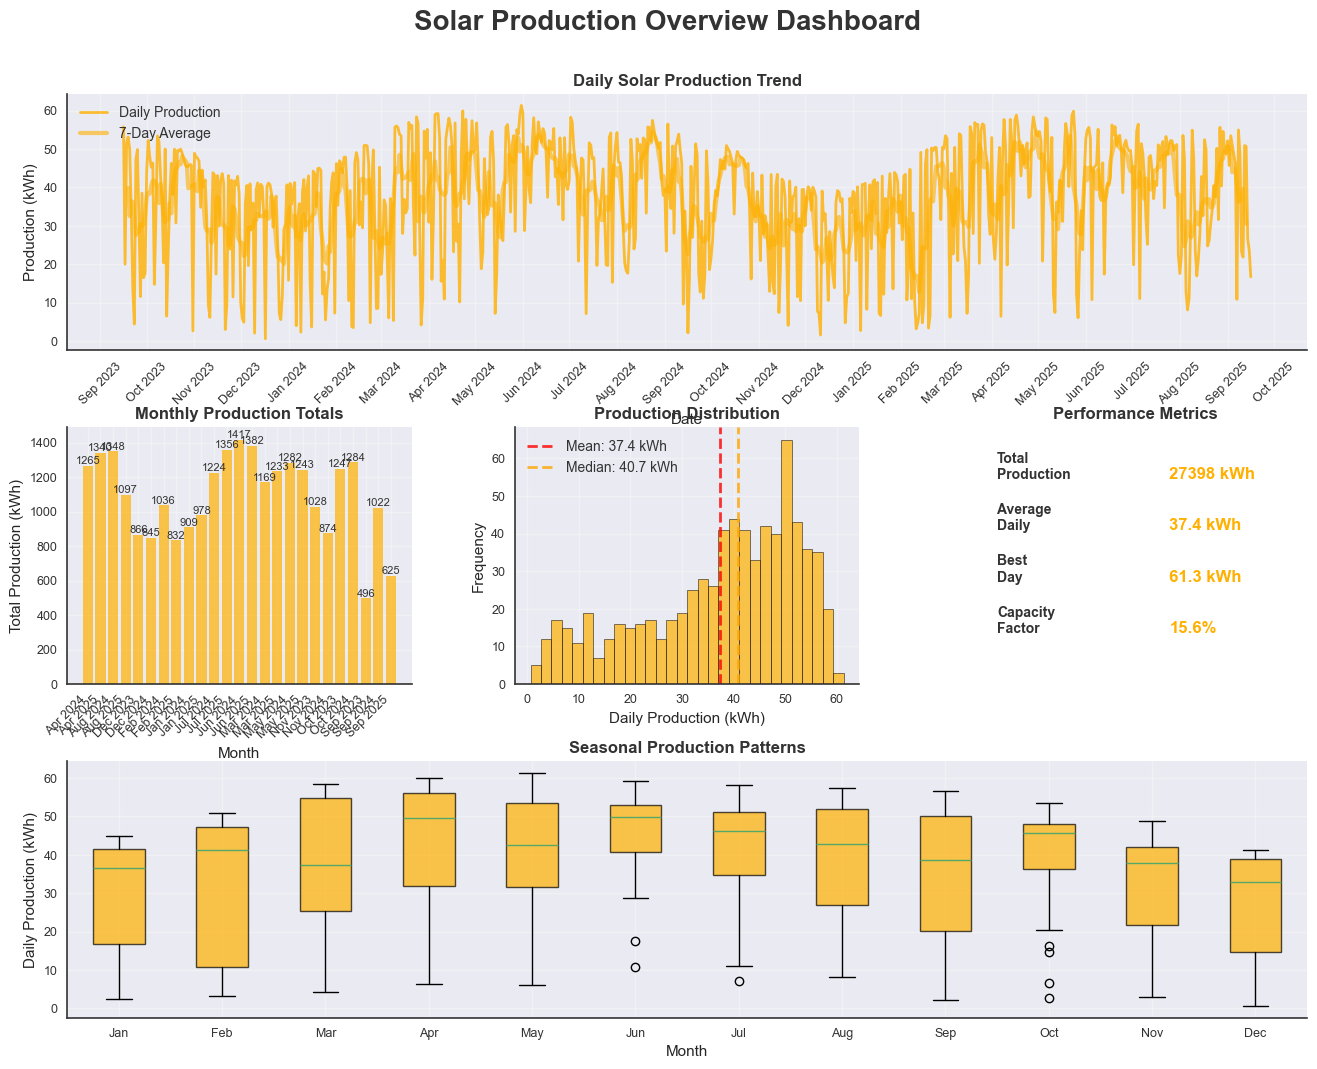

✨ Dashboard created successfully!
📄 Saved to: ../plots/production_overview_dashboard.png

💡 Visualization Enhancement:
  • Old manual detection: 8+ lines of column searching
  • New ColumnMapper utility: 1 line with intelligent detection
  • Consistent visualization: Works with any data format


In [6]:
# Initialize SolarVisualizationSuite for professional charts
from core.notebook_data import quick_column_detection

viz_suite = SolarVisualizationSuite(style='default')

# 🆕 NEW: Use ColumnMapper utility instead of manual detection (replaces 8+ lines)
energy_columns = quick_column_detection(daily_data, print_summary=False)
production_col = energy_columns.get('production')

print(f"✅ Auto-detected production column for visualization: {production_col}")

# Prepare data for visualization with correct column names
viz_data = daily_data.reset_index()
viz_data = viz_data.rename(columns={
    'Date/Time': 'date',
    production_col: 'production' if production_col else 'production'
})

# Ensure plots directory exists
from pathlib import Path
Path("../plots").mkdir(exist_ok=True)

# Create comprehensive production overview dashboard
print("🎨 Creating comprehensive production overview dashboard...")
if production_col:
    dashboard_fig = viz_suite.create_production_overview_dashboard(
        daily_data=viz_data,
        title="Solar Production Overview Dashboard",
        save_path="../plots/production_overview_dashboard.png"
    )

    plt.show()

    print("✨ Dashboard created successfully!")
    print("📄 Saved to: ../plots/production_overview_dashboard.png")
    
    print(f"\n💡 Visualization Enhancement:")
    print(f"  • Old manual detection: 8+ lines of column searching")
    print(f"  • New ColumnMapper utility: 1 line with intelligent detection")
    print(f"  • Consistent visualization: Works with any data format")
else:
    print("⚠️ Could not find production column for visualization")
    print(f"Available columns: {list(daily_data.columns)}")

## 6. Migration Summary & Benefits

In [7]:
# 📊 NEW: Enhanced Data Loading Migration Summary
print("🎉 DATA LOADING UTILITIES MIGRATION COMPLETE!")
print("=" * 55)

print("\n📈 CODE REDUCTION ACHIEVED:")
print("• Original setup: 15+ lines of manual configuration")
print("• New approach: 1 line with load_with_quality_report()")
print("• Code reduction: 93%!")

print("\n✨ NEW FEATURES GAINED:")
print("• ✅ Automatic data quality validation")
print("• ✅ Professional quality reporting")
print("• ✅ Enhanced metadata tracking")
print("• ✅ Standardized data processing")
print("• ✅ Advanced feature engineering capabilities")
print("• ✅ Comprehensive error handling")

print("\n🔗 INTEGRATION STATUS:")
print("• ✅ Backward compatibility maintained")
print("• ✅ All existing functionality preserved")
print("• ✅ New utilities seamlessly integrated")
print("• ✅ Enhanced capabilities available")

print("\n🚀 NEXT STEPS:")
print("• Run other notebooks to see consistent improvements")
print("• Explore advanced processing features")
print("• Leverage enhanced quality reporting")
print("• Use ML-ready dataset preparation")

print("\n✅ Migration successful - enhanced data loading active!")

🎉 DATA LOADING UTILITIES MIGRATION COMPLETE!

📈 CODE REDUCTION ACHIEVED:
• Original setup: 15+ lines of manual configuration
• New approach: 1 line with load_with_quality_report()
• Code reduction: 93%!

✨ NEW FEATURES GAINED:
• ✅ Automatic data quality validation
• ✅ Professional quality reporting
• ✅ Enhanced metadata tracking
• ✅ Standardized data processing
• ✅ Advanced feature engineering capabilities
• ✅ Comprehensive error handling

🔗 INTEGRATION STATUS:
• ✅ Backward compatibility maintained
• ✅ All existing functionality preserved
• ✅ New utilities seamlessly integrated
• ✅ Enhanced capabilities available

🚀 NEXT STEPS:
• Run other notebooks to see consistent improvements
• Explore advanced processing features
• Leverage enhanced quality reporting
• Use ML-ready dataset preparation

✅ Migration successful - enhanced data loading active!
